In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow.keras as keras
from tqdm import tqdm
from google.colab import drive
import os
import cv2
import pickle
import json
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

In [3]:
# Check GPU available
#tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10367102074757700530, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16962858255481693865
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3555833688685042522
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4686571630056896652
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [4]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
path = "/content/drive/My Drive"
os.chdir(path)
os.listdir(path)

['Getting started.pdf',
 'daibingze-cv-new.pdf',
 'Colab Notebooks',
 'plant-pathology-2020-fgvc7',
 'VGG_history.pkl',
 'Project teams.xlsx',
 'VGG_history_aug.pkl',
 'HOGSVM.ipynb',
 'GraySVM.ipynb',
 'submissiongooglef.csv',
 'submission.csv',
 'submissiongooglenof.csv']

In [6]:
submission=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/sample_submission.csv')
train=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/train.csv')
test=pd.read_csv('/content/drive/My Drive/plant-pathology-2020-fgvc7/test.csv')

train.head()
test.head()
submission.head()



,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [7]:
# Load training set
train_img=[]
train_label=[]
path='/content/drive/My Drive/plant-pathology-2020-fgvc7/images'
for im in tqdm(train['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    img=img.astype('float32')
    train_img.append(img)

# Load test set
test_img=[]
path='/content/drive/My Drive/plant-pathology-2020-fgvc7/images'
for im in tqdm(test['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    img=img.astype(('float32'))
    test_img.append(img)

100%|██████████| 1821/1821 [12:24<00:00,  2.45it/s]


In [8]:
# Create training labels
train_label=train.loc[:,'healthy':'scab']
train_img=np.array(train_img)
test_img=np.array(test_img)
train_label=np.array(train_label)

print(train_label)

print("Training set size:",train_img.shape)
print("Training label size:",train_label.shape)

[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Training set size: (1821, 224, 224, 3)
Training label size: (1821, 4)


In [0]:
# Image pre-processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_aug = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=False)  


In [10]:
# Train-val split 80-20 split. No K-fold at the moment
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_img, train_label, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1456, 224, 224, 3)
(365, 224, 224, 3)
(1456, 4)
(365, 4)


In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.layers import *
from keras.models import Sequential

Using TensorFlow backend.


In [12]:
# VGG16-based model + Dense(256) + Dense(4)
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3), pooling='avg')
model=Sequential()
model.add(base_model)
model.add(Dense(256,activation='relu'))
model.add(Dense(4,activation='softmax'))
base_model.trainable=False
model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

94658560/94653016 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 24,113,284
Trainable params: 525,572
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
BS = 16
EPOCHS = 30;
history_aug = model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
	validation_data=(X_val, y_val), 
	epochs=EPOCHS)

Epoch 1/30
91/91 [==============================] - 25s 271ms/step - loss: 0.7357 - accuracy: 0.7418 - val_loss: 1.1082 - val_accuracy: 0.5726
Epoch 2/30
91/91 [==============================] - 15s 165ms/step - loss: 0.5988 - accuracy: 0.7843 - val_loss: 1.4896 - val_accuracy: 0.5534
Epoch 3/30
91/91 [==============================] - 16s 172ms/step - loss: 0.4476 - accuracy: 0.8365 - val_loss: 1.2470 - val_accuracy: 0.5808
Epoch 4/30
91/91 [==============================] - 16s 175ms/step - loss: 0.4255 - accuracy: 0.8482 - val_loss: 1.1778 - val_accuracy: 0.5836
Epoch 5/30
91/91 [==============================] - 16s 172ms/step - loss: 0.3620 - accuracy: 0.8626 - val_loss: 0.9602 - val_accuracy: 0.6932
Epoch 6/30
91/91 [==============================] - 16s 173ms/step - loss: 0.3858 - accuracy: 0.8551 - val_loss: 1.2616 - val_accuracy: 0.5699
Epoch 7/30
91/91 [==============================] - 16s 174ms/step - loss: 0.3727 - accuracy: 0.8668 - val_loss: 1.2703 - val_accuracy: 0.6055

In [14]:
import tensorflow.keras as keras
base_model.trainable=True
model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
BS = 16
EPOCHS = 70;
history_aug = model.fit(data_aug.flow(X_train, y_train, batch_size = BS),
	validation_data=(X_val, y_val), 
	epochs=EPOCHS)

Epoch 1/70
91/91 [==============================] - 30s 330ms/step - loss: 0.0922 - accuracy: 0.9677 - val_loss: 0.4808 - val_accuracy: 0.8630
Epoch 2/70
91/91 [==============================] - 20s 224ms/step - loss: 0.0727 - accuracy: 0.9766 - val_loss: 0.3003 - val_accuracy: 0.9151
Epoch 3/70
91/91 [==============================] - 21s 232ms/step - loss: 0.0698 - accuracy: 0.9808 - val_loss: 0.2966 - val_accuracy: 0.9178
Epoch 4/70
91/91 [==============================] - 21s 233ms/step - loss: 0.0468 - accuracy: 0.9856 - val_loss: 0.2925 - val_accuracy: 0.9288
Epoch 5/70
91/91 [==============================] - 21s 231ms/step - loss: 0.0439 - accuracy: 0.9835 - val_loss: 0.2996 - val_accuracy: 0.9205
Epoch 6/70
91/91 [==============================] - 21s 230ms/step - loss: 0.0420 - accuracy: 0.9842 - val_loss: 0.3053 - val_accuracy: 0.9288
Epoch 7/70
91/91 [==============================] - 21s 232ms/step - loss: 0.0301 - accuracy: 0.9897 - val_loss: 0.3179 - val_accuracy: 0.9260

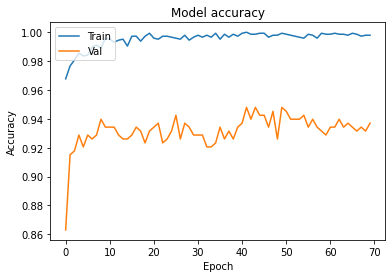

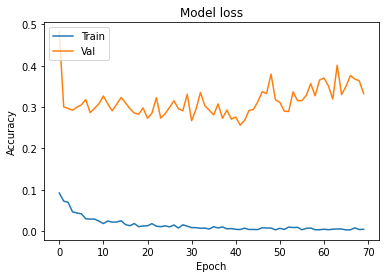

In [15]:
# Plot training loss and accuracy
history = history_aug
plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')





In [16]:
model.summary()
layer_outputs = [layer.output for layer in model.layers[0].layers]

# visualize_model = Model(inputs = model.layers[0].layers[0].input, outputs=layer_outputs)
# #visualize_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 24,113,284
Trainable params: 24,060,164
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
# from numpy import expand_dims
# train_img.shape
# img_idx = 9;
# img = train_img[img_idx,:,:,:]
# img = expand_dims(img, axis=0)
# img.shape
# feature_maps = visualize_model.predict(img)
# feature_maps[1].shape

# # plot all 64 maps in an 8x8 squares
# plt.figure()
# from PIL import Image
# img_img = Image.fromarray(img[0,:,:,:].astype('uint8')).convert('RGB')
# plt.imshow(img_img)

# # plt.figure()
# idx = 1
# fig, axes = plt.subplots(nrows=4, ncols=16)
# for ax in axes.flat:
#     im = ax.imshow(feature_maps[17][0, :, :, idx-1], cmap='viridis')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     idx+=1
# fig.colorbar(im, ax=axes.ravel().tolist())
# fig.set_figheight(8)
# fig.set_figwidth(32)
# # plt.suptitle('Hidden Layer Activation')

In [0]:
# def featVisualization(visualize_model, img):
#     from numpy import expand_dims
#     from PIL import Image
#     img = expand_dims(img, axis=0)
#     img.shape
#     feature_maps = visualize_model.predict(img)
#     feature_maps[1].shape

#     # plot all 64 maps in an 8x8 squares
#     plt.figure()
#     img_img = Image.fromarray(img[0,:,:,:].astype('uint8')).convert('RGB')
#     plt.imshow(img_img)

#     # plt.figure()
#     idx = 1
#     fig, axes = plt.subplots(nrows=4, ncols=16)
#     for ax in axes.flat:
#         im = ax.imshow(feature_maps[17][0, :, :, idx-1], cmap='viridis')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         idx+=1
#     fig.colorbar(im, ax=axes.ravel().tolist())
#     fig.set_figheight(8)
#     fig.set_figwidth(32)

In [0]:
# img_idx = 9;
# img = train_img[img_idx,:,:,:]
# featVisualization(visualize_model, img)

In [0]:
# Save training results
# f = open("./results/VGG_history_aug.pkl","wb")
# pickle.dump(history.history,f)
# f.close()

In [0]:
#  Load old training results
# new_history = pickle.load( open( "./results/VGG_history.pkl", "rb" ) )


In [0]:
# submission
y_pred = model.predict(test_img)


submission.loc[:,'healthy':'scab'] = y_pred
submission.to_csv('submissionresf.csv',index = False)

In [0]:
# PLot confusion matrix

val_pred = model.predict(X_val)

In [24]:
pred_index = np.argmax(val_pred,1)
y_val_index = np.argmax(y_val,1)
type(pred_index)

numpy.ndarray

In [25]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_val_index, pred_index)

array([[ 97,   0,   1,   1],
       [  3,   9,   4,   3],
       [  2,   0, 118,   0],
       [  5,   2,   2, 118]])